# Projet n°7: Implémentez un modèle de scoring

In [1]:
#!pip install xgboost

In [2]:
#!pip install lightgbm

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time
from functions import *

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [3]:
train = pd.read_csv("data/application_train.csv")
test = pd.read_csv("data/application_test.csv")
bureau = pd.read_csv("data/bureau.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")
credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
home_credit = pd.read_csv("data/HomeCredit_columns_description.csv", encoding="latin1")
installments_payments = pd.read_csv("data/installments_payments.csv")
pos_cash = pd.read_csv("data/POS_CASH_balance.csv")
previous_app = pd.read_csv("data/previous_application.csv")
sample_sub = pd.read_csv("data/sample_submission.csv")

## Aperçu des datasets chargés

In [6]:
home_credit.sample(5)

,Unnamed: 0,Table,Row,Description,Special
106,109,application_{train|test}.csv,FLAG_DOCUMENT_12,Did client provide document 12,NaN
31,34,application_{train|test}.csv,REGION_RATING_CLIENT_W_CITY,Our rating of the region where client lives wi...,NaN
139,142,bureau_balance.csv,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...,hashed
104,107,application_{train|test}.csv,FLAG_DOCUMENT_10,Did client provide document 10,NaN
192,195,previous_application.csv,NAME_PAYMENT_TYPE,Payment method that client chose to pay for th...,NaN


In [ ]:
train.shape

In [ ]:
test.shape

In [7]:
home_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [9]:
train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
184799,314208,0,Revolving loans,M,Y,Y,0,135000.0,270000.0,13500.0,270000.0,Unaccompanied,State servant,Secondary / secondary special,Single / not married,House / apartment,0.011703,-8608,-1541,-8577.0,-1268,0.0,1,1,0,1,0,0,Laborers,1.0,2,2,SATURDAY,17,0,0,0,0,0,0,Business Entity Type 1,0.142061,0.285898,0.265049,0.0557,0.0624,0.9806,0.7348,0.0059,0.00,0.1034,0.1667,0.2083,0.0478,0.0454,0.0500,0.0000,0.0000,0.0567,0.0647,0.9806,0.7452,0.0060,0.0000,0.1034,0.1667,0.2083,0.0489,0.0496,0.0521,0.0000,0.0000,0.0562,0.0624,0.9806,0.7383,0.0059,0.00,0.1034,0.1667,0.2083,0.0486,0.0462,0.0509,0.0000,0.0000,not specified,block of flats,0.0393,"Stone, brick",No,2.0,1.0,2.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
53161,161569,1,Revolving loans,F,N,N,0,180000.0,180000.0,9000.0,180000.0,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,0.014464,-8042,-1217,-7989.0,-709,NaN,1,1,1,1,1,0,Sales staff,1.0,2,2,THURSDAY,6,0,0,0,0,0,0,Self-employed,NaN,0.019185,0.050286,0.0680,0.0809,0.9757,0.6668,0.0091,0.00,0.1379,0.1667,0.2083,0.0375,0.0538,0.0505,0.0077,0.0529,0.0693,0.0840,0.9757,0.6798,0.0092,0.0000,0.1379,0.1667,0.2083,0.0383,0.0588,0.0526,0.0078,0.0560,0.0687,0.0809,0.9757,0.6713,0.0092,0.00,0.1379,0.1667,0.2083,0.0381,0.0547,0.0514,0.0078,0.0540,reg oper account,block of flats,0.0562,"Stone, brick",No,0.0,0.0,0.0,0.0,-415.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
122829,242414,0,Cash loans,F,N,Y,1,103500.0,270000.0,15628.5,270000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.019689,-11549,-3552,-3542.0,-2506,NaN,1,1,1,1,0,0,Sales staff,3.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,NaN,0.603153,0.215182,0.0515,0.0699,0.9866,NaN,NaN,0.00,0.1724,0.1667,NaN

In [10]:
train["SK_ID_CURR"].nunique()

307511

In [11]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [12]:
bureau.sample()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
242411,394607,5794604,Closed,currency 1,-1009,0,-602.0,-602.0,NaN,0,63751.5,0.0,NaN,0.0,Credit card,-602,NaN


In [13]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [14]:
bureau_balance.sample()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
8333599,6429361,-56,C


In [15]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [16]:
credit_card_balance.sample()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
406969,1231409,386932,-16,0.0,0,0.0,0.0,0.0,0.0,0.0,878.22,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,3.0,Active,0,0


In [17]:
installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [18]:
installments_payments.sample()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
7295479,2822437,272750,1.0,10,-250.0,-276.0,14677.38,347.58


In [19]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [20]:
pos_cash.sample()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
6653555,1705349,403241,-8,12.0,8.0,Active,0,0


In [21]:
previous_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [22]:
previous_app.sample()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1099463,2269919,164048,Consumer loans,3666.915,22455.0,22455.0,0.0,22455.0,FRIDAY,16,Y,1,0.0,NaN,NaN,XAP,Approved,-1440,Cash through the bank,XAP,NaN,New,Photo / Cinema Equipment,POS,XNA,Country-wide,4,Connectivity,8.0,high,POS mobile with interest,365243.0,-1378.0,-1168.0,-1228.0,-1220.0,0.0


In [23]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SK_ID_CURR  48744 non-null  int64  
 1   TARGET      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


In [24]:
sample_sub.sample()

,SK_ID_CURR,TARGET
5127,137286,0.5


## Exploration des données

In [25]:
def display_plot_target(data, col, size=(12,7)):    
    fig, ax = plt.subplots(figsize=size)

    # KDE plot of loans that were repaid on time
    sns.kdeplot(data.loc[data['TARGET'] == 0, col], label = 'target == 0')

    # KDE plot of loans which were not repaid on time
    sns.kdeplot(data.loc[data['TARGET'] == 1, col], label = 'target == 1')

    ax.legend(wedges, leg,
              loc="center left",
              fontsize = 'x-large',
              bbox_to_anchor=(1, 0, 0.5, 1))
    # Labeling of plot
    plt.xlabel(col)
    plt.ylabel('Densité')
    plt.title('Distribution de {}'.format(col), fontsize=20)
    plt.show()

#### Catégories

In [26]:
def feature_type_split(data):
    cat_list = []
    dis_num_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        elif data[i].nunique() < 25:
            dis_num_list.append(i)
        else:
            num_list.append(i)
    return cat_list, dis_num_list, num_list

In [27]:
cat_list, dis_num_list, num_list = feature_type_split(train) 

In [28]:
print(str(len(cat_list)),'variables catégorielles:\n', cat_list)
print('-----------------------------------------')
print(str(len(dis_num_list)),'variables numériques discrètes:\n',dis_num_list)
print('-----------------------------------------')
print(str(len(num_list)),'variables numériques continues:\n',num_list)

16 variables catégorielles:
 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
-----------------------------------------
45 variables numériques discrètes:
 ['TARGET', 'CNT_CHILDREN', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUME

#### Target

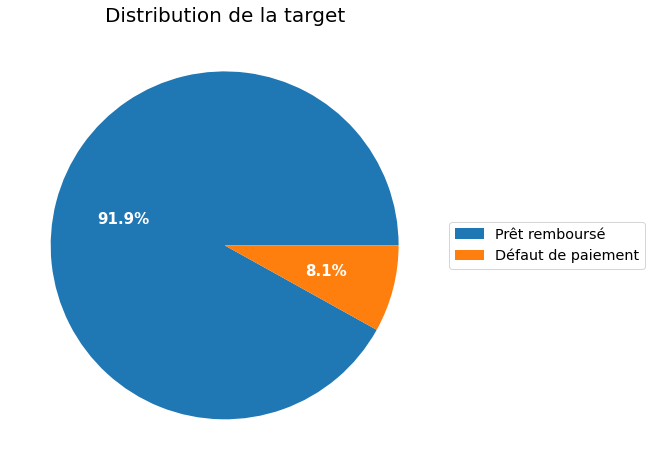

In [29]:
target_distribution = train['TARGET'].value_counts()
leg = ['Prêt remboursé', 'Défaut de paiement']

fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(target_distribution,
                                  autopct=lambda v: "{:0.1f}%".format(v))
ax.set_title("Distribution de la target", fontsize = 20)
ax.legend(wedges, leg,
          loc="center left",
          fontsize = 'x-large',
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold", color='w')
plt.show()


Observation du déséquilibre significatif entre les deux grandeurs pour les valeurs de la target.  
-> Equilibrage nécéssaire !

### Recherche d'outliers

In [30]:
train['DAYS_BIRTH'].iloc[0]

-9461

In [31]:
train['DAYS_BIRTH'].iloc[0] / -365

25.92054794520548

In [32]:
(train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Le format des âges est sous forme de "jours passés sur Terre", avec des entiers négatifs.  
On ne constate aucune anomalie sur les données des âges des clients

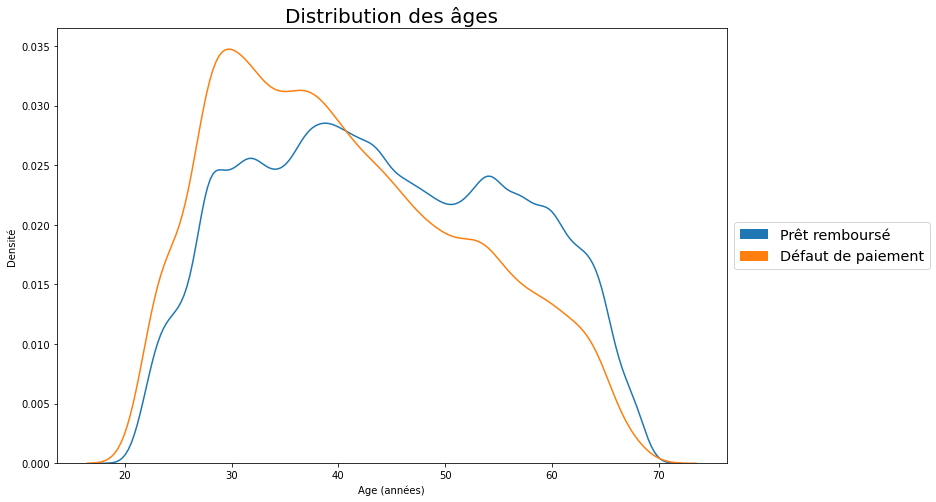

In [33]:
fig, ax = plt.subplots(figsize=(12,8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

ax.legend(wedges, leg,
          loc="center left",
          fontsize = 'x-large',
          bbox_to_anchor=(1, 0, 0.5, 1))
# Labeling of plot
plt.xlabel('Age (années)')
plt.ylabel('Densité')
plt.title('Distribution des âges', fontsize=20)
plt.show()

In [34]:
train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [35]:
train['DAYS_EMPLOYED'].max() / 365 

1000.6657534246575

Pour la durée travaillé, sous la même forme que l'âge, on constate ici un problème  
avec le max qui est une valeur positive et qui correspond à plus de 1000 ans!  
  
  
HYPOTHESE : les concepteurs du dataset ont volontairement mis une valeur abérrante pour des données manquantes,   
dans notre cas on va garder une valeur abérrante mais diminuer son impact en la divisant par 10.

In [36]:
outliers_days_empl = train[train['DAYS_EMPLOYED'] == 365243]
na_outliers_days_empl = train[train['DAYS_EMPLOYED'] != 365243]

In [37]:
print("Target avec outliers : {} \nTarget sans outliers : {}".format(
                    outliers_days_empl['TARGET'].mean() * 100, na_outliers_days_empl['TARGET'].mean() * 100))

Target avec outliers : 5.399646043269405 
Target sans outliers : 8.65997453765215


In [38]:
train['DAYS_EMPLOYED'][train['DAYS_EMPLOYED'] == 365243]

8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

#### Variables EXT_SOURCE

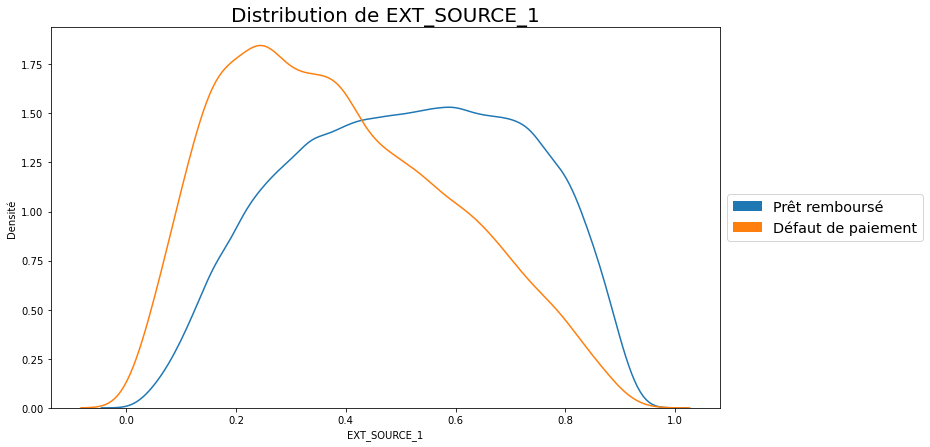

In [39]:
display_plot_target(train, 'EXT_SOURCE_1')

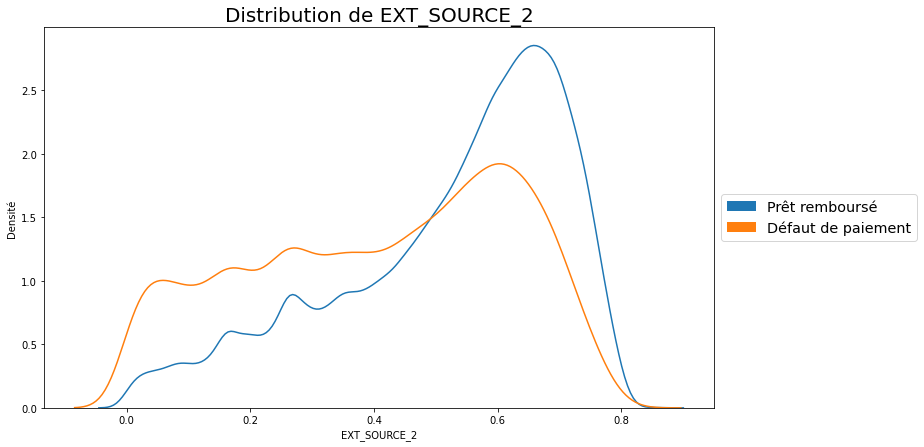

In [40]:
display_plot_target(train, 'EXT_SOURCE_2')

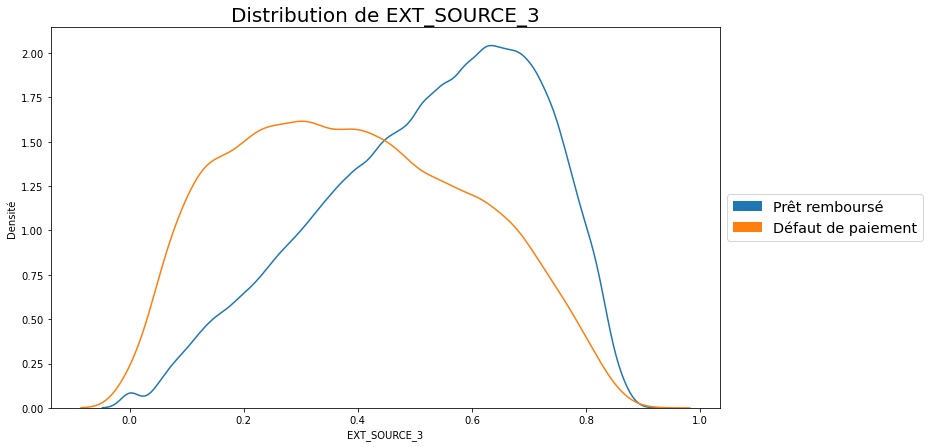

In [41]:
display_plot_target(train, 'EXT_SOURCE_3')

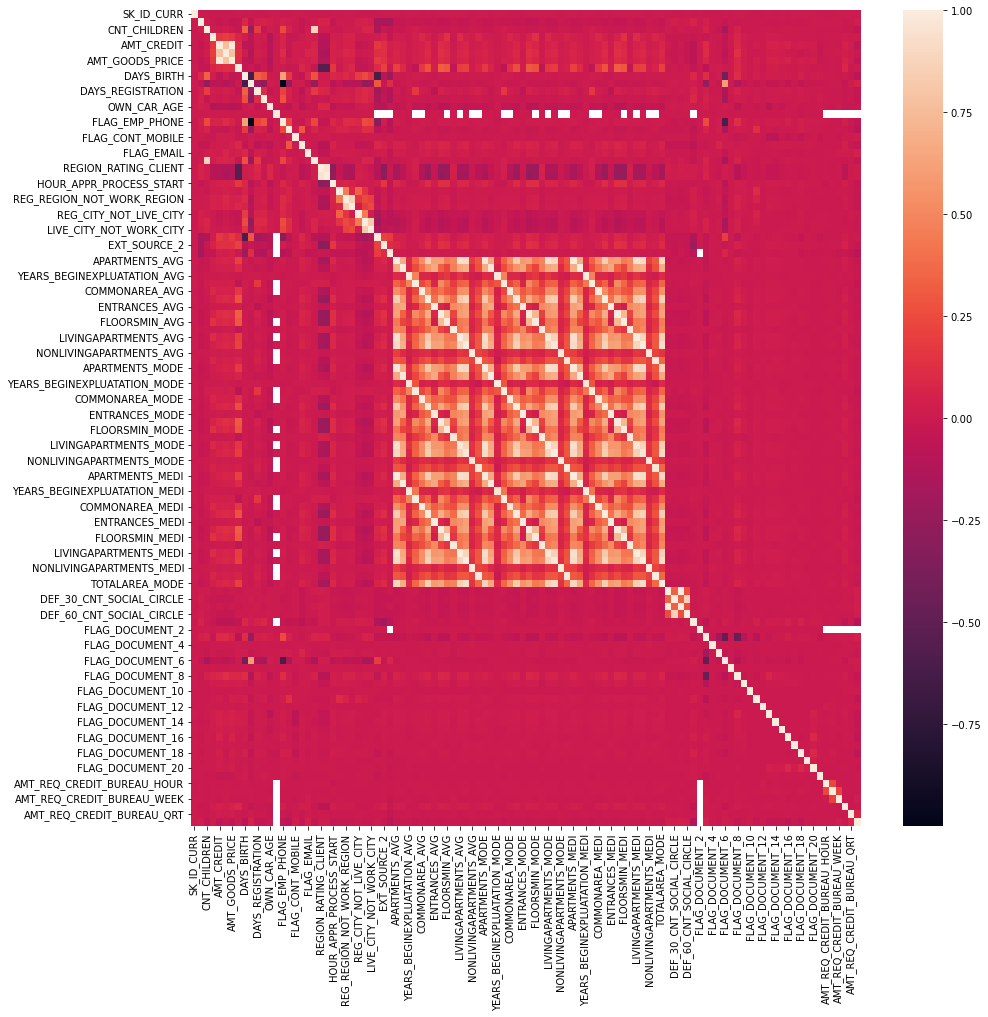

In [42]:
corr_mat = train.corr()
plt.figure(figsize=[15, 15])
sns.heatmap(corr_mat)
plt.show()

In [43]:
train.shape

(307511, 122)

### Création de nouvelles features

In [44]:
#Montant du crédit/Annuité = Terme du crédit en année
train['TERM'] = train.AMT_CREDIT / train.AMT_ANNUITY
test['TERM'] = test.AMT_CREDIT / test.AMT_ANNUITY

In [45]:
#Montant du crédit supérieur au "bon montant du crédit"
train['OVER_EXPECT_CREDIT'] = (train.AMT_CREDIT > train.AMT_GOODS_PRICE).map({False:0, True:1})
test['OVER_EXPECT_CREDIT'] = (test.AMT_CREDIT > test.AMT_GOODS_PRICE).map({False:0, True:1})

In [46]:
train['DEBT_RATIO'] = train.AMT_ANNUITY*100/train.AMT_INCOME_TOTAL
test['DEBT_RATIO'] = test.AMT_ANNUITY*100/test.AMT_INCOME_TOTAL

In [47]:
flag_doc_index = train.iloc[:,train.columns.str.startswith('FLAG_DOCUMENT_')].columns.tolist()
flag_doc_index

['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [48]:
#Total des documents recensés
train['FLAG_DOCUMENT_TOTAL'] = train.loc[:,flag_doc_index].sum(axis=1)
test['FLAG_DOCUMENT_TOTAL'] = test.loc[:,flag_doc_index].sum(axis=1)

In [49]:
train.drop(columns=flag_doc_index, inplace=True)
test.drop(columns=flag_doc_index, inplace=True)

In [50]:
req_index = train.iloc[:,train.columns.str.startswith('AMT_REQ_CREDIT_BUREAU_')].columns.tolist()
req_index

['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [51]:
#Total de demande de renseignements
train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = train.loc[:, req_index].sum(axis=1)
test['AMT_REQ_CREDIT_BUREAU_TOTAL'] = test.loc[:, req_index].sum(axis=1)
train.drop(columns=req_index, inplace=True)
test.drop(columns=req_index, inplace=True)

In [52]:
#
train['BIRTH_EMPLOTED_INTERVEL'] = train.DAYS_BIRTH / -365 - train.DAYS_EMPLOYED / -365
test['BIRTH_EMPLOTED_INTERVEL'] = test.DAYS_BIRTH / -365 - test.DAYS_EMPLOYED / -365

In [53]:
train['DAYS_BIRTH']

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

In [54]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: x/-365 if x < 0 else 0)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x: x/-365 if x < 0 else 0)

In [55]:
train['DAYS_BIRTH']

0         25.920548
1         45.931507
2         52.180822
3         52.068493
4         54.608219
            ...    
307506    25.553425
307507    56.917808
307508    41.002740
307509    32.769863
307510    46.180822
Name: DAYS_BIRTH, Length: 307511, dtype: float64

In [100]:
test['DAYS_BIRTH']

0        52.715068
1        49.490411
2        54.898630
3        38.290411
4        35.726027
           ...    
48739    54.712329
48740    30.646575
48741    43.621918
48742    38.268493
48743    38.252055
Name: DAYS_BIRTH, Length: 48744, dtype: float64

In [56]:
train['DAYS_EMPLOYED']

0           -637
1          -1188
2           -225
3          -3039
4          -3038
           ...  
307506      -236
307507    365243
307508     -7921
307509     -4786
307510     -1262
Name: DAYS_EMPLOYED, Length: 307511, dtype: int64

In [57]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: x/-365 if x < 0 else 0)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: x/-365 if x < 0 else 0)

In [58]:
#
train['BIRTH_REGISTRATION_INTERVEL'] = train.DAYS_REGISTRATION - train.DAYS_BIRTH
test['BIRTH_REGISTRATION_INTERVEL'] = test.DAYS_REGISTRATION - test.DAYS_BIRTH

In [59]:
#Revenu par membre de la famille
train['INCOME_PER_FAMILY_MEMBER'] = train.AMT_INCOME_TOTAL / train.CNT_FAM_MEMBERS
test['INCOME_PER_FAMILY_MEMBER'] = test.AMT_INCOME_TOTAL / test.CNT_FAM_MEMBERS

In [60]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,TERM,OVER_EXPECT_CREDIT,DEBT_RATIO,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOTED_INTERVEL,BIRTH_REGISTRATION_INTERVEL,INCOME_PER_FAMILY_MEMBER
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,25.920548,1.745205,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,16.461104,1,12.197778,1,1.0,24.175342,-3673.920548,202500.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,45.931507,3.254795,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,36.234085,1,13.221667,1,0.0,42.676712,-1231.931507,135000.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,52.180822,0.616438,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,20.000000,0,10.000000,0,0.0,51.564384,-4312.180822,67500.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,5

In [61]:
train["ORGANIZATION_TYPE"].unique()

array(['Business Entity Type 3', 'School', 'Government', 'Religion',
       'Other', 'XNA', 'Electricity', 'Medicine',
       'Business Entity Type 2', 'Self-employed', 'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'I

---

In [62]:
dict_organization_type = {
    
    'Business Entity Type 1' : 'Business Entity',
    'Business Entity Type 2' : 'Business Entity',
    'Business Entity Type 3' : 'Business Entity',
    'Business Entity Type 4' : 'Business Entity',
    
    'Agriculture' : 'Agriculture',
    
    'School' : 'School',
    'University' : 'School',
    
    'Government' : 'Government',
    
    'Religion' : 'Religion',
    
    'Electricity' : 'Electricity',
    
    'Medicine' : 'Medicine',
    
    'Self-employed' : 'Self-employed',
    
    'Transport: type 1' : 'Transport',
    'Transport: type 2' : 'Transport',
    'Transport: type 3' : 'Transport',
    
    'Trade: type 1' : 'Trade',
    'Trade: type 2' : 'Trade',
    'Trade: type 3' : 'Trade',
    'Trade: type 4' : 'Trade',
    'Trade: type 5' : 'Trade',
    'Trade: type 6' : 'Trade',
    
    'Industry: type 1': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 3': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    
    'Construction' : 'Construction',
    
    'Housing' : 'Housing',
    
    'Kindergarten' : 'Kindergarten',
    
    'Military' : 'Military',
    
    'Services' : 'Services',
    'Postal' : 'Services',
    'Cleaning' : 'Services',
    
    'Security Ministries' : 'Security Ministries',
    
    'Security' : 'Security',
    'Police' : 'Security',
    
    'Emergency' : 'Emergency',
    
    'Restaurant' : 'Restaurant/Hotel',
    'Hotel' : 'Restaurant/Hotel',
    
    'Culture' : 'Culture',
    
    'Telecom' : 'Telecom',
    
    'Bank': 'Bank/Insurance',
    'Insurance' : 'Bank/Insurance',
    
    'Other' : 'Other',
    'XNA' : 'Other',
    
}

In [63]:
train['ORGANIZATION_TYPE'] = train['ORGANIZATION_TYPE'].apply(cat, args=[dict_organization_type])

In [64]:
train["ORGANIZATION_TYPE"].unique()

array(['Business Entity', 'School', 'Government', 'Religion', 'Other',
       'Electricity', 'Medicine', 'Self-employed', 'Transport',
       'Construction', 'Housing', 'Kindergarten', 'Industry', 'Military',
       'Services', 'Security Ministries', 'Emergency', 'Security',
       'Trade', 'Agriculture', 'Restaurant/Hotel', 'Culture',
       'Bank/Insurance', 'Telecom'], dtype=object)

##### Utilisation du dataset "Bureau"

In [65]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'CNT_PREV_LOAN'})
previous_loan_counts.head()

,SK_ID_CURR,CNT_PREV_LOAN
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [66]:
#train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'inner')
#train['CNT_PREV_LOAN'] = train['CNT_PREV_LOAN'].fillna(0)
#train.head()

In [67]:
#display_plot_target(train, 'CNT_PREV_LOAN')

In [68]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean max min sum               count        mean     max     min     sum   
0  0.0   0   0   0                   7   82.428571  1778.0 -1329.0   577.0   
1  0.0   0   0   0                   6 -349.000000   780.0 -1072.0 -2094.0   
2  0.0   0   0   0                   4 -544.500000  1216.0 -2434.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -382.0  -595.0  -977.0   
4  0.0   0   0   0                   3  439.333333  1324.0  -128.0  1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean    max     min     sum   
0                 4  -825.500000 -544.0 -1328.0 -3302.0   
1                 6  -697.500000  -36.0 -1185.0 -4185.0   
2                 3 -1097.333333 -540.0 -2131.0 -3292.0   
3                 2  -532.500000 -382.0  -683.0 -1065.0   
4                 1  -123.000000 -123.0  -123.0  -123.0   

  AMT_CREDIT_MAX_OVERDUE                                     \
                   count      mean       max  min       sum   
0                      0       NaN       NaN  NaN     0.000   
1                      5  1681.029  5043.645  0.0  8405.145   
2                      4     0.000     0.000  0.0     0.000   
3                      1     0.000     0.000  0.0     0.000   
4                      1     0.000     0.000  0.0     0.000   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                           \
               count mean max min sum          count           mean       max   
0                  7  0.0   0   0   0              7  207623.571429  378000.0   
1                  8  0.0   0   0   0              8  108131.945625  450000.0   
2                  4  0.0   0   0   0              4  254350.125000  810000.0   
3                  2  0.0   0   0   0              2   94518.900000   94537.8   
4                  3  0.0   0   0   0              3  219042.000000  568800.0   

                        AMT_CREDIT_SUM_DEBT                                \
       min          sum               count           mean       max  min   
0  85500.0  1453365.000                   7   85240.928571  373239.0  0.0   
1      0.0   865055.565                   5   49156.200000  245781.0  0.0   
2  22248.0  1017400.500                   4       0.000000       0.0  0.0   
3  94500.0   189037.800                   2       0.000000       0.0  0.0   
4  29826.0   657126.000                   3  189469.500000  543087.0  0.0   

            AMT_CREDIT_SUM_LIMIT                                             \
        sum                count          mean         max  min         sum   
0  596686.5                    6       0.00000       0.000  0.0       0.000   
1  245781.0                    4    7997.14125   31988.565  0.0   31988.565   
2       0.0                    4  202500.00000  810000.000  0.0  810000.000   
3       0.0                    2       0.00000       0.000  0.0       0.000   
4  568408.5                    3       0.00000       0.000  0.0       0.000   

  AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE              \
                   count mean  max  min  sum              count        mean   
0                      7  0.0  0.0  0.0  0.0                  7  -93.142857   
1                      8  0.0  0.0  0.0  0.0                  8 -499.875000   
2                      4  0.0  0.0  0.0  0.0                  4 -816.000000   
3 

In [69]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,215354


In [70]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1      CREDIT_CURRENCY_currency 2       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001                              7  1.0                          0  0.0   
100002                              8  1.0                          0  0.0   
100003                              4  1.0                          0  0.0   
100004                              2  1.0                          0  0.0   
100005                              3  1.0                          0  0.0   

           CREDIT_CURRENCY_currency 3      CREDIT_CURRENCY_currency 4       \
                                  sum mean                        sum mean   
SK_ID_CURR                                                                   
100001                              0  0.0                          0  0.0   
100002                              0  0.0                          0  0.0   
100003                              0  0.0                          0  0.0   
100004                              0  0.0                          0  0.0   
100005                              0  0.0                          0  0.0   

           CREDIT_TYPE_Another type of loan      CREDIT_TYPE_Car loan       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Cash loan (non-earmarked)       \
                                             sum mean   
SK_ID_CURR                                              
100001                                         0  0.0   
100002                                         0  0.0   
100003                                         0  0.0   
100004                                         0  0.0   
100005                                         0  0.0   

           CREDIT_TYPE_Consumer credit           CREDIT_TYPE_Credit card  \
                                   sum      mean                     sum   
SK_ID_CURR                                                                 
100001                               7  1.000000                       0   
100002                               4  0.500000                       4   
100003                               2  0.500000                       2   
100004                               2  1.000000                       0   
100005   

### Aggrégation sur les datasets (généralisation)

In [71]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT,BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT_NORM,BUREAU_CREDIT_ACTIVE_BAD DEBT_COUNT,BUREAU_CREDIT_ACTIVE_BAD DEBT_COUNT_NORM,BUREAU_CREDIT_ACTIVE_CLOSED_COUNT,BUREAU_CREDIT_ACTIVE_CLOSED_COUNT_NORM,BUREAU_CREDIT_ACTIVE_SOLD_COUNT,BUREAU_CREDIT_ACTIVE_SOLD_COUNT_NORM,BUREAU_CREDIT_CURRENCY_CURRENCY 1_COUNT,BUREAU_CREDIT_CURRENCY_CURRENCY 1_COUNT_NORM,BUREAU_CREDIT_CURRENCY_CURRENCY 2_COUNT,BUREAU_CREDIT_CURRENCY_CURRENCY 2_COUNT_NORM,BUREAU_CREDIT_CURRENCY_CURRENCY 3_COUNT,BUREAU_CREDIT_CURRENCY_CURRENCY 3_COUNT_NORM,BUREAU_CREDIT_CURRENCY_CURRENCY 4_COUNT,BUREAU_CREDIT_CURRENCY_CURRENCY 4_COUNT_NORM,BUREAU_CREDIT_TYPE_ANOTHER TYPE OF LOAN_COUNT,BUREAU_CREDIT_TYPE_ANOTHER TYPE OF LOAN_COUNT_NORM,BUREAU_CREDIT_TYPE_CAR LOAN_COUNT,BUREAU_CREDIT_TYPE_CAR LOAN_COUNT_NORM,BUREAU_CREDIT_TYPE_CASH LOAN (NON-EARMARKED)_COUNT,BUREAU_CREDIT_TYPE_CASH LOAN (NON-EARMARKED)_COUNT_NORM,BUREAU_CREDIT_TYPE_CONSUMER CREDIT_COUNT,BUREAU_CREDIT_TYPE_CONSUMER CREDIT_COUNT_NORM,BUREAU_CREDIT_TYPE_CREDIT CARD_COUNT,BUREAU_CREDIT_TYPE_CREDIT CARD_COUNT_NORM,BUREAU_CREDIT_TYPE_INTERBANK CREDIT_COUNT,BUREAU_CREDIT_TYPE_INTERBANK CREDIT_COUNT_NORM,BUREAU_CREDIT_TYPE_LOAN FOR BUSINESS DEVELOPMENT_COUNT,BUREAU_CREDIT_TYPE_LOAN FOR BUSINESS DEVELOPMENT_COUNT_NORM,BUREAU_CREDIT_TYPE_LOAN FOR PURCHASE OF SHARES (MARGIN LENDING)_COUNT,BUREAU_CREDIT_TYPE_LOAN FOR PURCHASE OF SHARES (MARGIN LENDING)_COUNT_NORM,BUREAU_CREDIT_TYPE_LOAN FOR THE PURCHASE OF EQUIPMENT_COUNT,BUREAU_CREDIT_TYPE_LOAN FOR THE PURCHASE OF EQUIPMENT_COUNT_NORM,BUREAU_CREDIT_TYPE_LOAN FOR WORKING CAPITAL REPLENISHMENT_COUNT,BUREAU_CREDIT_TYPE_LOAN FOR WORKING CAPITAL REPLENISHMENT_COUNT_NORM,BUREAU_CREDIT_TYPE_MICROLOAN_COUNT,BUREAU_CREDIT_TYPE_MICROLOAN_COUNT_NORM,BUREAU_CREDIT_TYPE_MOBILE OPERATOR LOAN_COUNT,BUREAU_CREDIT_TYPE_MOBILE OPERATOR LOAN_COUNT_NORM,BUREAU_CREDIT_TYPE_MORTGAGE_COUNT,BUREAU_CREDIT_TYPE_MORTGAGE_COUNT_NORM,BUREAU_CREDIT_TYPE_REAL ESTATE LOAN_COUNT,BUREAU_CREDIT_TYPE_REAL ESTATE LOAN_COUNT_NORM,BUREAU_CREDIT_TYPE_UNKNOWN TYPE OF LOAN_COUNT,BUREAU_CREDIT_TYPE_UNKNOWN TYPE OF LOAN_COUNT_NORM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,7,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,4,0.500000,4,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.500000,2,0.500000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,1.000000,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,2,0.666667,1,0.333333,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [72]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

C:\Users\Mathieu\Documents\Python Scripts\P7\functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


,SK_ID_CURR,BUREAU_DAYS_CREDIT_COUNT,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_SUM,BUREAU_CREDIT_DAY_OVERDUE_COUNT,BUREAU_CREDIT_DAY_OVERDUE_MEAN,BUREAU_CREDIT_DAY_OVERDUE_MAX,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVERDUE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_COUNT,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_ENDDATE_FACT_COUNT,BUREAU_DAYS_ENDDATE_FACT_MEAN,BUREAU_DAYS_ENDDATE_FACT_MAX,BUREAU_DAYS_ENDDATE_FACT_MIN,BUREAU_DAYS_ENDDATE_FACT_SUM,BUREAU_AMT_CREDIT_MAX_OVERDUE_COUNT,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,BUREAU_CNT_CREDIT_PROLONG_COUNT,BUREAU_CNT_CREDIT_PROLONG_MEAN,BUREAU_CNT_CREDIT_PROLONG_MAX,BUREAU_CNT_CREDIT_PROLONG_MIN,BUREAU_CNT_CREDIT_PROLONG_SUM,BUREAU_AMT_CREDIT_SUM_COUNT,BUREAU_AMT_CREDIT_SUM_MEAN,BUREAU_AMT_CREDIT_SUM_MAX,BUREAU_AMT_CREDIT_SUM_MIN,BUREAU_AMT_CREDIT_SUM_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_COUNT,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MIN,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_LIMIT_COUNT,BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN,BUREAU_AMT_CREDIT_SUM_LIMIT_MAX,BUREAU_AMT_CREDIT_SUM_LIMIT_MIN,BUREAU_AMT_CREDIT_SUM_LIMIT_SUM,BUREAU_AMT_CREDIT_SUM_OVERDUE_COUNT,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_OVERDUE_MIN,BUREAU_AMT_CREDIT_SUM_OVERDUE_SUM,BUREAU_DAYS_CREDIT_UPDATE_COUNT,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_AMT_ANNUITY_COUNT,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_SUM
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,5,49156.200000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [73]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,BUREAU_BALANCE_STATUS_0_COUNT,BUREAU_BALANCE_STATUS_0_COUNT_NORM,BUREAU_BALANCE_STATUS_1_COUNT,BUREAU_BALANCE_STATUS_1_COUNT_NORM,BUREAU_BALANCE_STATUS_2_COUNT,BUREAU_BALANCE_STATUS_2_COUNT_NORM,BUREAU_BALANCE_STATUS_3_COUNT,BUREAU_BALANCE_STATUS_3_COUNT_NORM,BUREAU_BALANCE_STATUS_4_COUNT,BUREAU_BALANCE_STATUS_4_COUNT_NORM,BUREAU_BALANCE_STATUS_5_COUNT,BUREAU_BALANCE_STATUS_5_COUNT_NORM,BUREAU_BALANCE_STATUS_C_COUNT,BUREAU_BALANCE_STATUS_C_COUNT_NORM,BUREAU_BALANCE_STATUS_X_COUNT,BUREAU_BALANCE_STATUS_X_COUNT_NORM
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [74]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

C:\Users\Mathieu\Documents\Python Scripts\P7\functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


,SK_ID_BUREAU,BUREAU_BALANCE_MONTHS_BALANCE_COUNT,BUREAU_BALANCE_MONTHS_BALANCE_MEAN,BUREAU_BALANCE_MONTHS_BALANCE_MAX,BUREAU_BALANCE_MONTHS_BALANCE_MIN,BUREAU_BALANCE_MONTHS_BALANCE_SUM
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [75]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [76]:
original_features = list(train.columns)
print('Nombre de features avant traitement: ', len(original_features))

Nombre de features avant traitement:  104


In [77]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [78]:
new_features = list(train.columns)
print('Nombre de features avec les données des précédents prêts: ', len(new_features))


Nombre de features avec les données des précédents prêts:  315


### Observations des données manquantes

In [79]:
# Fonction qui calcule les données manquantes
def missing_values_table(df):
        # Total données manquantes
        mis_val = df.isnull().sum()
        
        # Pourcentage données manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Tableau avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renomme les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Valeurs manquantes', 1 : '% Total Données'})
        
        # Classement en fonciton du pourcentage de données manquantes
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% Total Données', ascending=False).round(1)
        
        # Affichage des infos résumés
        print ("Le dataframe a " + str(df.shape[1]) + " colonnes.\n"      
            "Il contient " + str(mis_val_table_ren_columns.shape[0]) +
              " colonnes avec des données manquantes.")
        
        # Retourne le tableau sur les données manquantes
        return mis_val_table_ren_columns

In [80]:
missing_values = missing_values_table(train)
missing_values.head(20)

Le dataframe a 315 colonnes.
Il contient 275 colonnes avec des données manquantes.


,Valeurs manquantes,% Total Données
BUREAU_AMT_ANNUITY_MAX,227502,74.0
BUREAU_AMT_ANNUITY_MIN,227502,74.0
BUREAU_AMT_ANNUITY_MEAN,227502,74.0
CLIENT_BUREAU_BALANCE_STATUS_5_COUNT_MIN,215280,70.0
CLIENT_BUREAU_BALANCE_STATUS_4_COUNT_MEAN,215280,70.0
CLIENT_BUREAU_BALANCE_STATUS_4_COUNT_MAX,215280,70.0
CLIENT_BUREAU_BALANCE_STATUS_4_COUNT_MIN,215280,70.0
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_MAX_MIN,215280,70.0
CLIENT_BUREAU_BALANCE_STATUS_4_COUNT_NORM_MEAN,215280,70.0
CLIENT_BUREAU_BALANCE_STATUS_4_COUNT_NORM_MAX,215280,70.0


#### Calcul des nouvelles données pour le test set

In [81]:
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [82]:
train.shape

(307511, 315)

In [83]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [84]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 315)
Testing Data Shape:  (48744, 314)


#### Corrélations

In [85]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [86]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
BUREAU_DAYS_CREDIT_MEAN,0.089729
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MEAN,0.089038
BUREAU_CREDIT_ACTIVE_ACTIVE_COUNT_NORM,0.077356
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_MEAN,0.076424
BUREAU_DAYS_CREDIT_MIN,0.075248
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_MIN_MIN,0.073225
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_SUM_MEAN,0.072606
BUREAU_DAYS_CREDIT_UPDATE_MEAN,0.068927
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_SUM_MIN,0.068072


In [87]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
CLIENT_BUREAU_BALANCE_STATUS_C_COUNT_NORM_MEAN,-0.055936
CLIENT_BUREAU_BALANCE_STATUS_C_COUNT_MAX,-0.061083
CLIENT_BUREAU_BALANCE_STATUS_C_COUNT_MEAN,-0.062954
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_COUNT_MAX,-0.068792
DAYS_BIRTH,-0.078239
BUREAU_CREDIT_ACTIVE_CLOSED_COUNT_NORM,-0.079369
CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_COUNT_MEAN,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


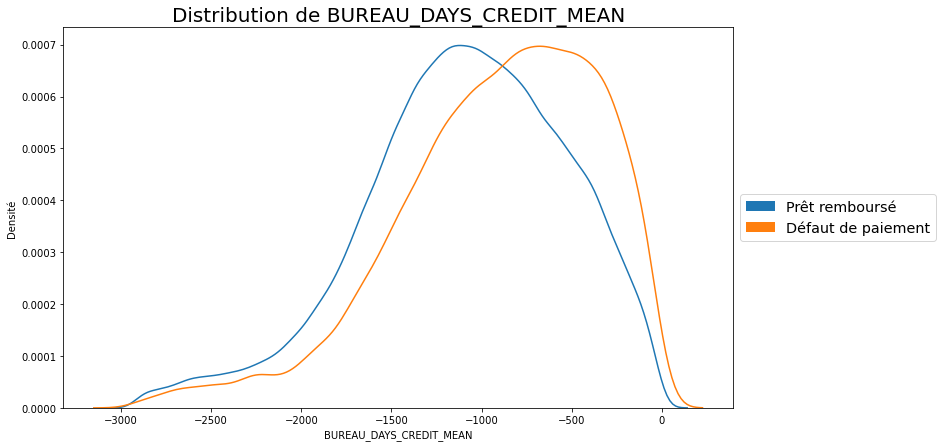

In [88]:
display_plot_target(train, 'BUREAU_DAYS_CREDIT_MEAN')

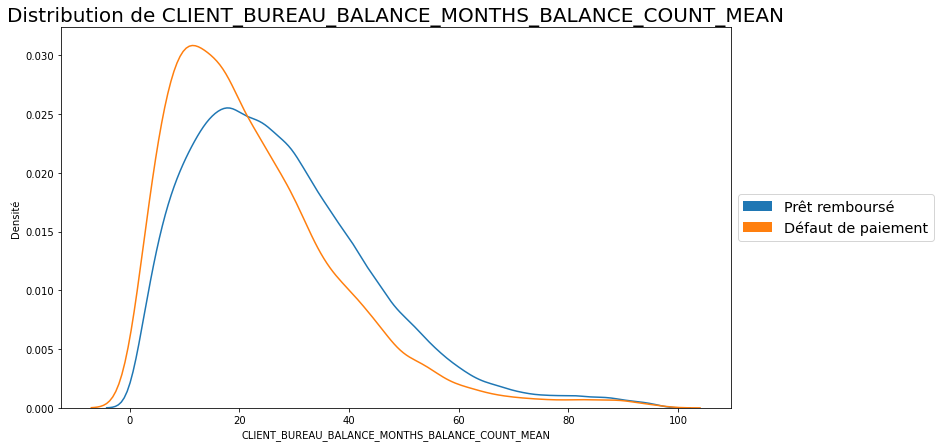

In [89]:
display_plot_target(train, 'CLIENT_BUREAU_BALANCE_MONTHS_BALANCE_COUNT_MEAN')

##### Corrélations entre variables

In [90]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [91]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Nombre de colonnes à supprimer: ', len(cols_to_remove))

Nombre de colonnes à supprimer:  136


In [92]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Dimensions Trainset après suppression des features corrélés: ', train_corrs_removed.shape)
print('Dimensions Testset après suppression des features corrélés: ', test_corrs_removed.shape)

Dimensions Trainset après suppression des features corrélés:  (307511, 179)
Dimensions Testset après suppression des features corrélés:  (48744, 178)


In [101]:
full_train = train.copy()
full_test = test.copy()

In [94]:
sample_train = train_corrs_removed.sample(50000, random_state = 1)
sample_test = test_corrs_removed.sample(15000, random_state = 1)

In [95]:
sample_train = category(sample_train)
sample_test = category(sample_test)

In [96]:
sample_test.to_csv("data/sample_test.csv", index=False)
sample_train.to_csv("data/sample_train.csv", index=False)

In [102]:
full_train.to_csv("data/full_train.csv", index=False)
full_test.to_csv("data/full_test.csv", index=False)

In [103]:
print(full_train.shape,full_test.shape)

(307511, 315) (48744, 314)


In [97]:
test_corrs_removed.to_csv("data/test_clean.csv", index=False)

In [98]:
train_corrs_removed.to_csv("data/train_clean.csv", index=False)

In [99]:
sample_train['TARGET'].value_counts()

0    45979
1     4021
Name: TARGET, dtype: int64